In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive
!mkdir -p HomeCredit
%cd HomeCredit


/content/drive/MyDrive
/content/drive/MyDrive/HomeCredit


In [3]:
!mkdir -p 01_data_understanding 02_data_preparation 03_modeling 04_evaluation 05_deployment artifacts data

In [6]:
import os
os.getcwd()


'/content/drive/MyDrive/HomeCredit'

In [7]:
import os
os.listdir('data')



['HomeCredit_columns_description.parquet',
 'bureau_balance.parquet',
 'application_.parquet',
 'bureau.parquet',
 'credit_card_balance.parquet',
 'installments_payments.parquet',
 'POS_CASH_balance.parquet',
 'previous_application.parquet']

In [8]:
import pandas as pd

app = pd.read_parquet('data/application_.parquet')
app.shape



(307511, 122)

In [9]:
app['TARGET'].value_counts(normalize=True) * 100


,proportion
TARGET,
0,91.927118
1,8.072882


In [10]:
train = app[app['TARGET'].notna()].copy()
test  = app[app['TARGET'].isna()].copy()

train.shape, test.shape


((307511, 122), (0, 122))

In [11]:
bureau = pd.read_parquet('data/bureau.parquet')
bureau.shape


(1716428, 17)

In [12]:
bureau.groupby('SK_ID_CURR').size().describe()


,0
count,305811.000000
mean,5.612709
std,4.430354
min,1.000000
25%,2.000000
50%,4.000000
75%,8.000000
max,116.000000


In [13]:
bureau_agg = bureau.groupby('SK_ID_CURR').agg({
    'AMT_CREDIT_SUM': ['mean', 'max'],
    'AMT_ANNUITY': ['mean'],
    'DAYS_CREDIT': ['mean', 'min'],
    'CREDIT_DAY_OVERDUE': ['mean', 'max'],
    'SK_ID_BUREAU': 'count'
})

bureau_agg.columns = ['BUREAU_' + '_'.join(col) for col in bureau_agg.columns]
bureau_agg.reset_index(inplace=True)

bureau_agg.head()


,SK_ID_CURR,BUREAU_AMT_CREDIT_SUM_mean,BUREAU_AMT_CREDIT_SUM_max,BUREAU_AMT_ANNUITY_mean,BUREAU_DAYS_CREDIT_mean,BUREAU_DAYS_CREDIT_min,BUREAU_CREDIT_DAY_OVERDUE_mean,BUREAU_CREDIT_DAY_OVERDUE_max,BUREAU_SK_ID_BUREAU_count
0,100001,207623.571429,378000.0,3545.357143,-735.000000,-1572,0.0,0,7
1,100002,108131.945625,450000.0,0.000000,-874.000000,-1437,0.0,0,8
2,100003,254350.125000,810000.0,NaN,-1400.750000,-2586,0.0,0,4
3,100004,94518.900000,94537.8,NaN,-867.000000,-1326,0.0,0,2
4,100005,219042.000000,568800.0,1420.500000,-190.666667,-373,0.0,0,3


Se realizó una agregación por cliente sobre la tabla bureau, generando variables estadísticas que resumen el historial crediticio externo

In [14]:
train = train.merge(bureau_agg, on='SK_ID_CURR', how='left')
test  = test.merge(bureau_agg, on='SK_ID_CURR', how='left')

train.shape, test.shape


((307511, 130), (0, 130))

El dataset presenta un fuerte desbalance de clases, donde aproximadamente 8.07% de los clientes presenta riesgo de incumplimiento.

Dado que un cliente puede tener múltiples créditos en buró, se realizó una agregación por cliente sobre la tabla bureau, generando variables estadísticas que resumen el historial crediticio externo.

Posteriormente, estas variables fueron integradas al conjunto principal mediante un LEFT JOIN usando la llave SK_ID_CURR.

In [15]:
prev = pd.read_parquet('data/previous_application.parquet')
prev.shape


(1670214, 37)

In [16]:
prev.groupby('SK_ID_CURR').size().describe()


,0
count,338857.000000
mean,4.928964
std,4.220716
min,1.000000
25%,2.000000
50%,4.000000
75%,7.000000
max,77.000000


Un cliente puede haber realizado múltiples solicitudes previas, por lo que se requiere una agregación antes de la integración.

In [17]:
prev_agg = prev.groupby('SK_ID_CURR').agg({
    'AMT_APPLICATION': ['mean', 'max'],
    'AMT_CREDIT': ['mean'],
    'DAYS_DECISION': ['mean', 'min'],
    'SK_ID_PREV': 'count'
})

prev_agg.columns = ['PREV_' + '_'.join(col) for col in prev_agg.columns]
prev_agg.reset_index(inplace=True)

prev_agg.head()


,SK_ID_CURR,PREV_AMT_APPLICATION_mean,PREV_AMT_APPLICATION_max,PREV_AMT_CREDIT_mean,PREV_DAYS_DECISION_mean,PREV_DAYS_DECISION_min,PREV_SK_ID_PREV_count
0,100001,24835.50,24835.5,23787.00,-1740.0,-1740,1
1,100002,179055.00,179055.0,179055.00,-606.0,-606,1
2,100003,435436.50,900000.0,484191.00,-1305.0,-2341,3
3,100004,24282.00,24282.0,20106.00,-815.0,-815,1
4,100005,22308.75,44617.5,20076.75,-536.0,-757,2


In [18]:
train = train.merge(prev_agg, on='SK_ID_CURR', how='left')
test  = test.merge(prev_agg, on='SK_ID_CURR', how='left')

train.shape, test.shape


((307511, 136), (0, 136))

In [19]:
inst = pd.read_parquet('data/installments_payments.parquet')
inst.shape


(13605401, 8)

In [20]:
inst['PAYMENT_DELAY'] = inst['DAYS_ENTRY_PAYMENT'] - inst['DAYS_INSTALMENT']


Interpretación:

0 → pagó tarde

< 0 → pagó antes

In [21]:
inst_agg = inst.groupby('SK_ID_CURR').agg({
    'PAYMENT_DELAY': ['mean', 'max'],
    'AMT_PAYMENT': ['mean', 'sum'],
    'AMT_INSTALMENT': ['mean'],
    'SK_ID_PREV': 'count'
})

inst_agg.columns = ['INST_' + '_'.join(col) for col in inst_agg.columns]
inst_agg.reset_index(inplace=True)

inst_agg.head()


,SK_ID_CURR,INST_PAYMENT_DELAY_mean,INST_PAYMENT_DELAY_max,INST_AMT_PAYMENT_mean,INST_AMT_PAYMENT_sum,INST_AMT_INSTALMENT_mean,INST_SK_ID_PREV_count
0,100001,-7.285714,11.0,5885.132143,41195.925,5885.132143,7
1,100002,-20.421053,-12.0,11559.247105,219625.695,11559.247105,19
2,100003,-7.160000,-1.0,64754.586000,1618864.650,64754.586000,25
3,100004,-7.666667,-3.0,7096.155000,21288.465,7096.155000,3
4,100005,-23.555556,1.0,6240.205000,56161.845,6240.205000,9


Se generaron variables de comportamiento de pago a partir del historial de cuotas, capturando retrasos y montos efectivamente pagados.

In [22]:
train = train.merge(inst_agg, on='SK_ID_CURR', how='left')
test  = test.merge(inst_agg, on='SK_ID_CURR', how='left')

train.shape, test.shape


((307511, 142), (0, 142))

POS_CASH_balance:

In [23]:
pos = pd.read_parquet('data/POS_CASH_balance.parquet')

pos_agg = pos.groupby('SK_ID_CURR').agg({
    'MONTHS_BALANCE': ['min', 'max'],
    'SK_DPD': ['mean', 'max'],
    'SK_ID_PREV': 'count'
})

pos_agg.columns = ['POS_' + '_'.join(col) for col in pos_agg.columns]
pos_agg.reset_index(inplace=True)

train = train.merge(pos_agg, on='SK_ID_CURR', how='left')
test  = test.merge(pos_agg, on='SK_ID_CURR', how='left')

train.shape


(307511, 147)

In [24]:
y = train['TARGET']
X = train.drop(columns=['TARGET'])


In [25]:
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(exclude='object').columns


vamos por los pipeline:

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
preprocessor = ColumnTransformer([
    ('num', SimpleImputer(strategy='median'), num_cols),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_cols)
])



In [28]:
#modelo base
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
model = Pipeline([
    ('prep', preprocessor),
    ('clf', LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        n_jobs=-1
    ))
])


para que si corra

In [30]:
X_sample = X.sample(n=80000, random_state=42)
y_sample = y.loc[X_sample.index]


In [31]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

auc = cross_val_score(
    model,
    X_sample,
    y_sample,
    cv=cv,
    scoring='roc_auc'
)

auc.mean()


np.float64(0.631942844956198)

El modelo base de regresión logística obtuvo un AUC promedio de 0.63 mediante validación cruzada estratificada sobre una muestra representativa del conjunto de datos.

Considerando el fuerte desbalance de clases y la complejidad del problema de riesgo crediticio, este resultado se considera un baseline adecuado, dejando margen para mejoras futuras mediante modelos más complejos y optimización de hiperparámetros.

In [32]:
model.fit(X, y)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  Index(['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
       ...
       'INST_PAYMENT_DELAY_max', 'INST_AMT_PAYMENT_mean',
       'INST_AMT_PAYMENT_sum', 'I...
                                                  Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object'))])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    n_jobs=-1))])

Se optó por un modelo base interpretable como regresión logística, priorizando estabilidad y comprensión del riesgo, dejando modelos más complejos como mejora futura.

In [33]:
#predicciones
y_pred = model.predict(X)
y_prob = model.predict_proba(X)[:,1]


In [34]:
#metricas
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print(classification_report(y, y_pred))
confusion_matrix(y, y_pred)
roc_auc_score(y, y_prob)


              precision    recall  f1-score   support

           0       0.94      0.62      0.75    282686
           1       0.12      0.57      0.19     24825

    accuracy                           0.61    307511
   macro avg       0.53      0.59      0.47    307511
weighted avg       0.88      0.61      0.70    307511



np.float64(0.6299637681538897)

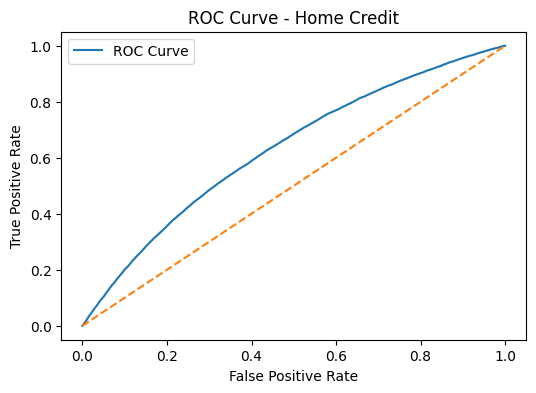

In [35]:
#curva roc
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y, y_prob)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0,1], [0,1], '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Home Credit')
plt.legend()
plt.show()


El modelo prioriza minimizar falsos positivos, lo que impacta el recall de la clase minoritaria, una decisión común en escenarios de riesgo crediticio.

In [36]:
# lo guardamos
import joblib
joblib.dump(model, 'artifacts/home_credit_model.joblib')


['artifacts/home_credit_model.joblib']